# Clustering using PySpark ML Pipeline
1. Imports
2. Load Data<br>&emsp;2.1 Split data<br>
3. Test Pipeline components <br>&emsp;3.1 Tokenize <br>&emsp;3.2 Count Vectorizer <br>&emsp;3.3 Logistic Regression <br>
4. Testing Pipeline<br>
5. Pipeline + Cross-validation + Tuning  **<======== Final pipeline**<br>&emsp;5.1 Define pipeline <br>&emsp;5.2 Define Hyper-parameter grid <br>&emsp;5.3 Define Cross validation params <br>&emsp;5.4 Get best CV model <br>&emsp;5.5 Predictions form best CV model <br>&emsp;5.6 Compute Eval metrics

## 1. Imports

In [0]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import  StringIndexer, OneHotEncoder,VectorAssembler,StandardScaler
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from sklearn.metrics import r2_score
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
spark = SparkSession.builder.getOrCreate()

## 2. Load Data

In [0]:
# Load file
data_sparkdf = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/{user-directory}/Online_Retail.csv")

In [0]:
data_sparkdf.count()

Out[9]: 541909

In [0]:
data_sparkdf.printSchema()

root
-- InvoiceNo: string (nullable = true)
-- StockCode: string (nullable = true)
-- Description: string (nullable = true)
-- Quantity: string (nullable = true)
-- InvoiceDate: string (nullable = true)
-- UnitPrice: string (nullable = true)
-- CustomerID: string (nullable = true)
-- Country: string (nullable = true)

In [0]:
### Datatype conversion
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

data_sparkdf = data_sparkdf.withColumn("Quantity",col("Quantity").cast('integer'))\
            .withColumn("UnitPrice",col("UnitPrice").cast('float'))\
            .withColumn('date',to_timestamp("InvoiceDate", 'MM/dd/yy HH:mm'))


data_sparkdf.printSchema()

root
-- InvoiceNo: string (nullable = true)
-- StockCode: string (nullable = true)
-- Description: string (nullable = true)
-- Quantity: integer (nullable = true)
-- InvoiceDate: string (nullable = true)
-- UnitPrice: float (nullable = true)
-- CustomerID: string (nullable = true)
-- Country: string (nullable = true)
-- date: timestamp (nullable = true)

In [0]:
data_sparkdf.show(2)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country| date|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
 536365| 85123A|WHITE HANGING HEA...| 6|12/1/2010 8:26| 2.55| 17850|United Kingdom|2010-12-01 08:26:00|
 536365| 71053| WHITE METAL LANTERN| 6|12/1/2010 8:26| 3.39| 17850|United Kingdom|2010-12-01 08:26:00|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
only showing top 2 rows

In [0]:
# Drop rows with empty customer IDs
data_sparkdf = data_sparkdf.na.drop(subset=["CustomerID"])
data_sparkdf.count()

Out[13]: 406829

In [0]:
# Removing data points with values less than 0
data_sparkdf = data_sparkdf.where(data_sparkdf.Quantity>0).where(data_sparkdf.UnitPrice>0)

## 3. EDA

In [0]:
# Register as temp table
data_sparkdf.createOrReplaceTempView("retail")

In [0]:
# Number of rows
spark.sql("SELECT COUNT(*) FROM retail").toPandas()

Out[16]:

,count(1)
0,397884


In [0]:
# unique customers
spark.sql("SELECT COUNT(DISTINCT(CustomerID)) FROM retail").toPandas()

Out[17]:

,count(DISTINCT CustomerID)
0,4338


In [0]:
# Country-wise purchase
spark.sql("SELECT Country,COUNT(*) purchase FROM retail GROUP BY Country ORDER BY purchase DESC ").toPandas().head(5)

Out[18]:

,Country,purchase
0,United Kingdom,354321
1,Germany,9040
2,France,8341
3,EIRE,7236
4,Spain,2484


In [0]:
# Most earliest & recent purchase date
spark.sql("SELECT MIN(date) earliest,MAX(date) recent FROM retail").toPandas().head(5)

Out[19]:

,earliest,recent
0,2010-12-01 08:26:00,2011-12-09 12:50:00


## 4. Data Pre-processing

The variables in this dataset are in a format that cannot be easily ingested into the customer segmentation model. These features individually do not tell us much about customer purchase behavior.

Due to this, we will use the existing variables to derive three new informative features - recency, frequency, and monetary value (RFM).

RFM is commonly used in marketing to evaluate a client’s value based on their:

- Recency: How recently has each customer made a purchase?
- Frequency: How often have they bought something?
- Monetary Value: How much money do they spend on average when making purchases?

### 4.1 Recency

In [0]:
# Create most recent date column
print(spark.sql("SELECT *,MAX(date) OVER(ORDER BY date DESC) from_date FROM retail").toPandas().head(5))
data_sparkdf = spark.sql("SELECT *,MAX(date) OVER(ORDER BY date DESC) from_date FROM retail")

InvoiceNo StockCode ... date from_date
0 581587 22631 ... 2011-12-09 12:50:00 2011-12-09 12:50:00
1 581587 22556 ... 2011-12-09 12:50:00 2011-12-09 12:50:00
2 581587 22555 ... 2011-12-09 12:50:00 2011-12-09 12:50:00
3 581587 22728 ... 2011-12-09 12:50:00 2011-12-09 12:50:00
4 581587 22727 ... 2011-12-09 12:50:00 2011-12-09 12:50:00

[5 rows x 10 columns]

In [0]:
# Calculate the recency score
data_sparkdf = data_sparkdf.withColumn('recency_days',datediff(col("from_date"),col("date"))+1)
data_sparkdf.show(2)

+---------+---------+--------------------+--------+---------------+---------+----------+-------+-------------------+-------------------+------------+
InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID|Country| date| from_date|recency_days|
+---------+---------+--------------------+--------+---------------+---------+----------+-------+-------------------+-------------------+------------+
 581587| 22631|CIRCUS PARADE LUN...| 12|12/9/2011 12:50| 1.95| 12680| France|2011-12-09 12:50:00|2011-12-09 12:50:00| 1|
 581587| 22556|PLASTERS IN TIN C...| 12|12/9/2011 12:50| 1.65| 12680| France|2011-12-09 12:50:00|2011-12-09 12:50:00| 1|
+---------+---------+--------------------+--------+---------------+---------+----------+-------+-------------------+-------------------+------------+
only showing top 2 rows

In [0]:
# Calculate most recent purchase by customer
data_sparkdf = data_sparkdf.join(data_sparkdf.groupby('CustomerID').agg(min('recency_days').alias('recency')),on='CustomerID',how='left')

data_sparkdf.show(2)

+----------+---------+---------+--------------------+--------+---------------+---------+-------+-------------------+-------------------+------------+-------+
CustomerID|InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|Country| date| from_date|recency_days|recency|
+----------+---------+---------+--------------------+--------+---------------+---------+-------+-------------------+-------------------+------------+-------+
 12680| 581587| 22631|CIRCUS PARADE LUN...| 12|12/9/2011 12:50| 1.95| France|2011-12-09 12:50:00|2011-12-09 12:50:00| 1| 1|
 12680| 581587| 22556|PLASTERS IN TIN C...| 12|12/9/2011 12:50| 1.65| France|2011-12-09 12:50:00|2011-12-09 12:50:00| 1| 1|
+----------+---------+---------+--------------------+--------+---------------+---------+-------+-------------------+-------------------+------------+-------+
only showing top 2 rows

### 4.2 Frequency

In [0]:
data_sparkdf = data_sparkdf.join(data_sparkdf.groupby('CustomerID').agg(count('InvoiceNo').alias('frequency')),on='CustomerID',how='inner')

In [0]:
data_sparkdf.show(2)

+----------+---------+---------+--------------------+--------+--------------+---------+---------+-------------------+-------------------+------------+-------+---------+
CustomerID|InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice| Country| date| from_date|recency_days|recency|frequency|
+----------+---------+---------+--------------------+--------+--------------+---------+---------+-------------------+-------------------+------------+-------+---------+
 12386| 540280| 21422|PORCELAIN ROSE SMALL| 80|1/6/2011 12:37| 0.85|Australia|2011-01-06 12:37:00|2011-12-09 12:50:00| 338| 338| 10|
 12386| 540280| 21421|PORCELAIN ROSE LA...| 60|1/6/2011 12:37| 1.25|Australia|2011-01-06 12:37:00|2011-12-09 12:50:00| 338| 338| 10|
+----------+---------+---------+--------------------+--------+--------------+---------+---------+-------------------+-------------------+------------+-------+---------+
only showing top 2 rows

### 4.3 Monetary Value

In [0]:
# Calculat total amount spent by each customer in one purchase
data_sparkdf = data_sparkdf.withColumn('TotalValue',col('UnitPrice')*col('Quantity'))

In [0]:
data_sparkdf = data_sparkdf.join(data_sparkdf.groupBy('CustomerID').agg(sum('TotalValue').alias('monetary_value')),on='CustomerID',how='inner')

In [0]:
data_sparkdf.show(2)

+----------+---------+---------+--------------------+--------+--------------+---------+---------+-------------------+-------------------+------------+-------+---------+----------+-----------------+
CustomerID|InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice| Country| date| from_date|recency_days|recency|frequency|TotalValue| monetary_value|
+----------+---------+---------+--------------------+--------+--------------+---------+---------+-------------------+-------------------+------------+-------+---------+----------+-----------------+
 12386| 540280| 21422|PORCELAIN ROSE SMALL| 80|1/6/2011 12:37| 0.85|Australia|2011-01-06 12:37:00|2011-12-09 12:50:00| 338| 338| 10| 68.0|401.8999938964844|
 12386| 540280| 21421|PORCELAIN ROSE LA...| 60|1/6/2011 12:37| 1.25|Australia|2011-01-06 12:37:00|2011-12-09 12:50:00| 338| 338| 10| 75.0|401.8999938964844|
+----------+---------+---------+--------------------+--------+--------------+---------+---------+-------------------+-------------------+------------+-------+---------+----------+-----------------+
only showing top 2 rows

### 4.4 Final Features

In [0]:
final_data_sparkdf = data_sparkdf.select(['recency','frequency','monetary_value','CustomerID']).distinct()
final_data_sparkdf.count()

Out[29]: 4338

In [0]:
final_data_sparkdf.show(4)

+-------+---------+------------------+----------+
recency|frequency| monetary_value|CustomerID|
+-------+---------+------------------+----------+
 326| 1| 77183.59375| 12346|
 3| 182| 4310.000016212463| 12347|
 76| 31|1797.2399997711182| 12348|
 19| 73|1757.5499963760376| 12349|
+-------+---------+------------------+----------+
only showing top 4 rows

### 4.5 Standardise Data

In [0]:
# Assemble features in a single columns
assemble=VectorAssembler(inputCols=['recency','frequency','monetary_value'], outputCol='assembled_features', handleInvalid="skip")
assembled_data_sparkdf =assemble.transform(final_data_sparkdf)

In [0]:
# Standardise features
scale=StandardScaler(inputCol='assembled_features',outputCol='features')
data_scale=scale.fit(assembled_data_sparkdf)
scaled_data_sparkdf =data_scale.transform(assembled_data_sparkdf)


## 5. Build K-means model

### 5.1 Finding number of clusters

In [0]:
# Find optimum number of clusters
cost ={}

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='features',k=i)
    KMeans_fit=KMeans_algo.fit(scaled_data_sparkdf)
    output=KMeans_fit.transform(scaled_data_sparkdf)
    cost[i] = KMeans_fit.summary.trainingCost
    print(i)


2
3
4
5
6
7
8
9

In [0]:
cost

Out[77]: {2: 9419.593788127331,
 3: 5450.967970863778,
 4: 3998.8155859512212,
 5: 3153.9046426764166,
 6: 2500.3099759883135,
 7: 1922.5732804789773,
 8: 1689.4986292413962,
 9: 1498.377533497909}

Out[5]:

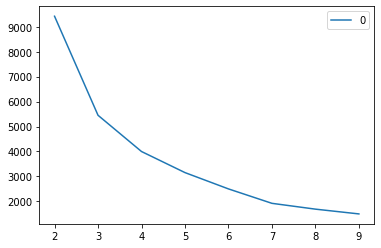

<AxesSubplot:>

In [0]:
pd.DataFrame.from_dict(cost,orient='index').plot(kind='line')

### 5.2 Building model based on k=4

In [0]:
KMeans_algo=KMeans(featuresCol='features',k=4)
KMeans_fit=KMeans_algo.fit(scaled_data_sparkdf)

### 5.3 Making predicitions

In [0]:
prediction = KMeans_fit.transform(scaled_data_sparkdf)

In [0]:
result_df = prediction.toPandas()
result_df.head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field assembled_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[58]:

,recency,frequency,monetary_value,CustomerID,assembled_features,features,prediction
0,1,230,3849.780006,12662,"[1.0, 230.0, 3849.7800064086914]","[0.009998773726221336, 1.0053102503583666, 0.4...",0
1,40,27,7330.799984,17396,"[40.0, 27.0, 7330.7999839782715]","[0.3999509490488534, 0.11801468156380826, 0.81...",0
2,4,235,1508.759992,16016,"[4.0, 235.0, 1508.759992301464]","[0.03999509490488534, 1.027164821018331, 0.167...",0
3,109,128,2037.079985,13593,"[109.0, 128.0, 2037.0799853801727]","[1.0898663361581256, 0.559477008895091, 0.2266...",0
4,157,93,446.869997,15889,"[157.0, 93.0, 446.8699966073036]","[1.5698074750167497, 0.4064950142753396, 0.049...",2


## 6. Cluster Analysis

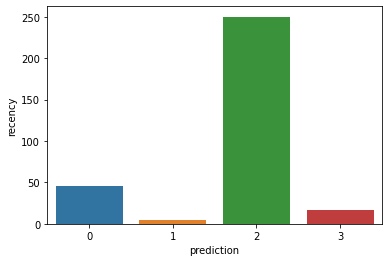

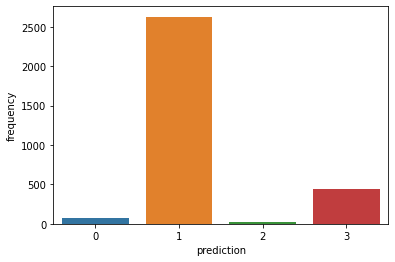

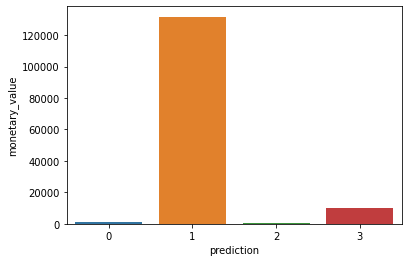

In [0]:
avg_df = result_df.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()